## Import modules

In [3]:
import pdb
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

import nhanes as nhanes
import importlib
importlib.reload(nhanes)

%matplotlib notebook

## Settings

In [4]:
DATA_PATH = '/Users/carolynyen1/Downloads/CS205/CS205-Project/CDC/NHANES/'
DATASET = 'cancer'

### Note: 
The code below loads each dataset: dataset_features, dataset_targets

Here, all datasets are defined explicitly (see nhanes.py).

In [5]:
ds = nhanes.Dataset(DATA_PATH)
ds.load_cancer()
n_fe = ds.features.shape[1]
n_classes = 2

indx = np.argwhere(ds.targets != 3)
dataset_features = ds.features[indx.flatten()]
dataset_targets = ds.targets[indx.flatten()]

Processing: BPQ_I.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## Mutual Information

In [ ]:
mut_in = mutual_info_classif(dataset_features, dataset_targets)
dataset_features = dataset_features.T[mut_in > 0].T
dataset_features.shape

(5714, 131)

## Train/Test Separation

In [ ]:
perm = np.random.permutation(dataset_targets.shape[0])
dataset_features = dataset_features[perm]
dataset_targets = dataset_targets[perm]

def get_batch(n_size, phase):
    # select indices
    n_samples = dataset_features.shape[0]
    n_classes = int(dataset_targets.max() + 1)
    if phase == 'test':
        inds_sel = np.arange(0, int(n_samples*0.15), 1)
    elif phase == 'validation':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.15), int(n_samples*0.30), 1)
    elif phase == 'train':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.30), n_samples, 1)
    else:
        raise NotImplementedError
    inds_sel = np.random.permutation(inds_sel)
    batch_inds = []
    for cl in range(n_classes):
        inds_cl = inds_sel[dataset_targets[inds_sel] == cl]
        batch_inds.extend(inds_cl[:n_size//n_classes])
    batch_inds = np.random.permutation(batch_inds)
    
    return dataset_features[batch_inds], dataset_targets[batch_inds]
    
features_trn, targets_trn = get_batch(n_size=5000, phase='train')
features_tst, targets_tst = get_batch(n_size=1000, phase='test')

## Classification

MLP 0.8164665523156089
Confusion matrix, without normalization
[[ 18  65]
 [ 42 458]]
              precision    recall  f1-score   support

           0       0.30      0.22      0.25        83
           1       0.88      0.92      0.90       500

   micro avg       0.82      0.82      0.82       583
   macro avg       0.59      0.57      0.57       583
weighted avg       0.79      0.82      0.80       583

Extra trees 0.8576329331046312
Confusion matrix, without normalization
[[ 12  71]
 [ 12 488]]
              precision    recall  f1-score   support

           0       0.50      0.14      0.22        83
           1       0.87      0.98      0.92       500

   micro avg       0.86      0.86      0.86       583
   macro avg       0.69      0.56      0.57       583
weighted avg       0.82      0.86      0.82       583

ada_classifier 0.8627787307032591
Confusion matrix, without normalization
[[ 22  61]
 [ 19 481]]
              precision    recall  f1-score   support

           0  

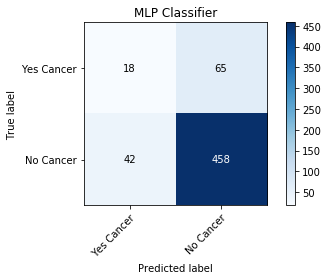

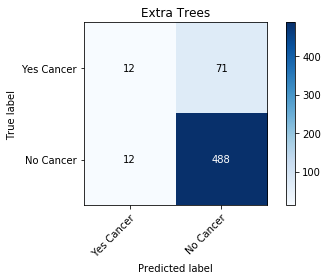

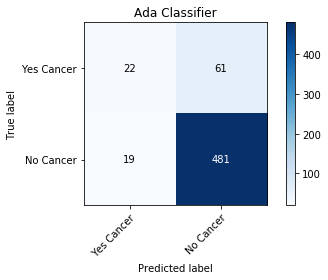

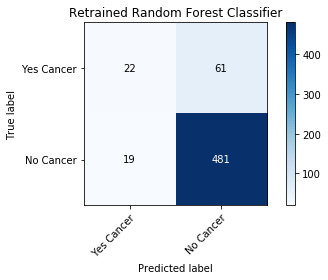

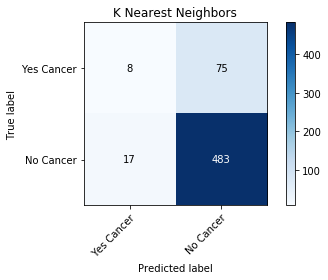

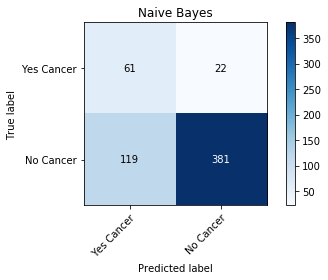

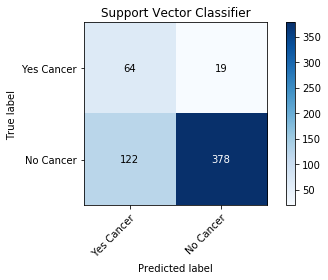

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(5,2), alpha=0.00001, solver='sgd', max_iter = 1000, batch_size = 40)
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
mlp = np.mean(preds_tst==targets_tst)
print('MLP', mlp)

from sklearn import metrics
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(targets_tst, preds_tst)
#print(cm)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='MLP Classifier')
from sklearn.metrics import classification_report
print(classification_report(targets_tst, preds_tst))

# fit an Extra Trees model to the data
clf = ExtraTreesClassifier(n_estimators=100, class_weight='balanced')
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('Extra trees', accu)

plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='Extra Trees')
print(classification_report(targets_tst, preds_tst))

clf = AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=0)
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
ada = np.mean(preds_tst==targets_tst)
print('ada_classifier', ada)

plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='Ada Classifier')
print(classification_report(targets_tst, preds_tst))

clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')
clf = clf.fit(features_trn, targets_trn)
sfm = SelectFromModel(clf, threshold=0.055)
sfm.fit(features_trn, targets_trn)
X_important_train = sfm.transform(features_trn)
X_important_test = sfm.transform(features_tst)
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, targets_trn)
y_pred = clf.predict(features_tst)
accuracy_score(targets_tst, y_pred)
y_important_pred = clf_important.predict(X_important_test)
#new_accu = accuracy_score(targets_tst, y_important_pred)
new_accu = np.mean(y_important_pred==targets_tst)
print('Retrained Random Forest', new_accu)

plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='Retrained Random Forest Classifier')
print(classification_report(targets_tst, preds_tst))

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('K Nearest Neighbors', accu)

plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='K Nearest Neighbors')
print(classification_report(targets_tst, preds_tst))

#Import Library
from sklearn.naive_bayes import GaussianNB
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create SVM classification object 
clf = GaussianNB(priors=None, var_smoothing=1e-02)
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('Naive Bayes', accu)

plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='Naive Bayes')
print(classification_report(targets_tst, preds_tst))

clf = SVC(gamma='auto',class_weight = 'balanced')
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_SVC', accu)

plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='Support Vector Classifier')
print(classification_report(targets_tst, preds_tst))

clf = LogisticRegression(solver='lbfgs', max_iter=600,class_weight = 'balanced')
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_LR', accu)

plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='Logistic Regression')
print(classification_report(targets_tst, preds_tst))

clf = RandomForestClassifier(n_estimators=100,class_weight = 'balanced')
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('Random Forest Classifier', accu)

plot_confusion_matrix(targets_tst,preds_tst,classes=['Yes Cancer', 'No Cancer'],title='Random Forest Classifier')
print(classification_report(targets_tst, preds_tst))
